# Import package

In [176]:
import keras
import os, io
import pickle
import random
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from google.cloud import storage
from assets.credential_key import key
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tensorflow.keras.layers import Dense, MaxPooling2D, BatchNormalization, Conv2D, Flatten, Activation, Dropout, Input

# Memilih data

In [123]:
# memuat kunci crendential
key.get_credential_key()
client = storage.Client()

In [125]:
def list_data_dir(bucket_name):

    # Dapatkan bucket
    bucket = client.bucket(bucket_name)

    # List semua blob (file) dalam bucket
    all_data = list(bucket.list_blobs())

    # List semua data directory untuk setiap tugas yang diinginkan
    task_01 = [blob for blob in all_data if 'T01' in blob.name]
    task_06 = [blob for blob in all_data if 'T06' in blob.name]
    task_20 = [blob for blob in all_data if 'T20' in blob.name]
    task_21 = [blob for blob in all_data if 'T21' in blob.name]
    task_22 = [blob for blob in all_data if 'T22' in blob.name]

    tasks_amount = (len(task_01), len(task_06), len(task_20), len(task_21), len(task_22))

    # Gabungkan semua tugas ke dalam satu daftar direktori
    all_task_dir = (task_01, task_06, task_20, task_21, task_22)

    return all_task_dir, tasks_amount

tasks_dir, task_amount = list_data_dir("fall-detection-bucket")
print(f'Task 01: {task_amount[0]}')
print(f'Task 06: {task_amount[1]}')
print(f'Task 20: {task_amount[2]}')
print(f'Task 21: {task_amount[3]}')
print(f'Task 22: {task_amount[4]}')

Task 01: 32
Task 06: 151
Task 20: 159
Task 21: 161
Task 22: 161


# Group Data

In [126]:
task_01 = tasks_dir[0]
task_06 = tasks_dir[1]
task_20 = tasks_dir[2]
task_21 = tasks_dir[3]
task_22 = tasks_dir[4]

In [127]:
length = []

for blob in task_22:
    # Unduh konten dari objek Blob
    blob_content = blob.download_as_string()

    # Baca konten CSV dari objek buffer
    data = pd.read_csv(io.BytesIO(blob_content))

    # Tambahkan jumlah baris ke dalam daftar length
    length.append(data.shape[0])

# Hitung rata-rata jumlah baris
average_length = np.mean(np.array(length))
print("Average number of rows:", average_length)

Average number of rows: 719.9627329192547


In [128]:
task_01

[<Blob: fall-detection-bucket, sensor_data/SA06/S06T01R01.csv, 1717633208412376>,
 <Blob: fall-detection-bucket, sensor_data/SA07/S07T01R01.csv, 1717633250922810>,
 <Blob: fall-detection-bucket, sensor_data/SA08/S08T01R01.csv, 1717633279439543>,
 <Blob: fall-detection-bucket, sensor_data/SA09/S09T01R01.csv, 1717633401925516>,
 <Blob: fall-detection-bucket, sensor_data/SA10/S10T01R01.csv, 1717633450250931>,
 <Blob: fall-detection-bucket, sensor_data/SA11/S11T01R01.csv, 1717633534619107>,
 <Blob: fall-detection-bucket, sensor_data/SA12/S12T01R01.csv, 1717633622078189>,
 <Blob: fall-detection-bucket, sensor_data/SA13/S13T01R01.csv, 1717633657197665>,
 <Blob: fall-detection-bucket, sensor_data/SA14/S14T01R01.csv, 1717722078662913>,
 <Blob: fall-detection-bucket, sensor_data/SA15/S15T01R01.csv, 1717633688867477>,
 <Blob: fall-detection-bucket, sensor_data/SA16/S16T01R01.csv, 1717634149181872>,
 <Blob: fall-detection-bucket, sensor_data/SA17/S17T01R01.csv, 1717634228309592>,
 <Blob: fall-det

In [129]:
def group_tasks(task_blobs, task_name):
    all_data = []
    for blob in task_blobs:
        # Unduh konten dari objek Blob sebagai string
        blob_content = blob.download_as_string()

        # Baca konten CSV dari objek buffer
        df = pd.read_csv(io.BytesIO(blob_content))

        # Buang kolom yang tidak diperlukan
        drop_cols = ['TimeStamp(s)', 'FrameCounter', 'EulerX', 'EulerY', 'EulerZ']
        df.drop(columns=drop_cols, inplace=True)

        # Ubah DataFrame menjadi numpy array dan tambahkan ke dalam list all_data
        all_data.append(df.to_numpy())

    # Buat folder alldata jika belum ada
    if not os.path.exists('../../assets/pkl'):
        os.makedirs('../../assets/pkl')

    # Simpan list all_data ke dalam file .pkl
    joblib.dump(all_data, f'../../assets/pkl/{task_name}.pkl')

    print('Done!')

In [130]:
group_tasks(task_01, 'task_01')
group_tasks(task_06, 'task_06')
group_tasks(task_20, 'task_20')
group_tasks(task_21, 'task_21')
group_tasks(task_22, 'task_22')

Done!
Done!
Done!
Done!
Done!


In [131]:
def check_shape(bin):
    data = joblib.load(bin)
    for i in data:
        print(i.shape)

check_shape('../../assets/pkl/task_21.pkl')

(470, 6)
(448, 6)
(462, 6)
(467, 6)
(517, 6)
(582, 6)
(563, 6)
(672, 6)
(558, 6)
(523, 6)
(507, 6)
(506, 6)
(531, 6)
(505, 6)
(580, 6)
(575, 6)
(550, 6)
(559, 6)
(585, 6)
(552, 6)
(810, 6)
(688, 6)
(699, 6)
(722, 6)
(647, 6)
(748, 6)
(616, 6)
(606, 6)
(656, 6)
(629, 6)
(751, 6)
(591, 6)
(591, 6)
(605, 6)
(594, 6)
(676, 6)
(702, 6)
(758, 6)
(695, 6)
(750, 6)
(595, 6)
(618, 6)
(650, 6)
(605, 6)
(645, 6)
(659, 6)
(555, 6)
(723, 6)
(712, 6)
(710, 6)
(589, 6)
(660, 6)
(664, 6)
(675, 6)
(648, 6)
(685, 6)
(914, 6)
(920, 6)
(959, 6)
(910, 6)
(885, 6)
(837, 6)
(874, 6)
(850, 6)
(835, 6)
(853, 6)
(786, 6)
(790, 6)
(835, 6)
(621, 6)
(824, 6)
(775, 6)
(707, 6)
(663, 6)
(709, 6)
(741, 6)
(743, 6)
(687, 6)
(725, 6)
(715, 6)
(708, 6)
(714, 6)
(671, 6)
(741, 6)
(762, 6)
(764, 6)
(715, 6)
(674, 6)
(625, 6)
(704, 6)
(663, 6)
(675, 6)
(735, 6)
(812, 6)
(870, 6)
(872, 6)
(847, 6)
(758, 6)
(874, 6)
(830, 6)
(746, 6)
(716, 6)
(786, 6)
(873, 6)
(802, 6)
(782, 6)
(766, 6)
(877, 6)
(988, 6)
(961, 6)
(872, 6)
(

Data ke-8


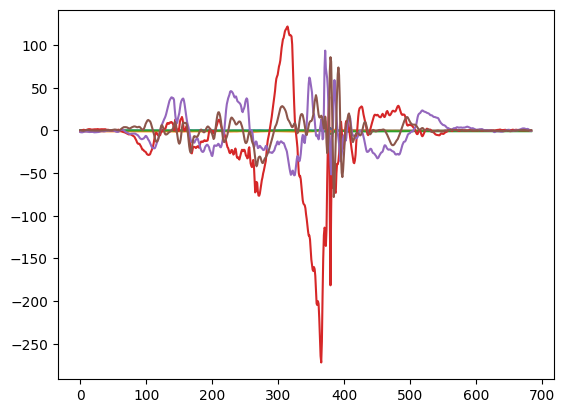

In [132]:
r = random.randint(0, 160)
data = joblib.load('../../assets/pkl/task_20.pkl')

print(f'Data ke-{r}')
plt.plot(data[r])

In [133]:
def exclude_data(data, length):
    ldata = joblib.load(data)
    exc = [i for i in ldata if i.shape[0] >= length]

    return exc

In [134]:
utask_01 = exclude_data('../../assets/pkl/task_01.pkl', 600)
utask_06 = exclude_data('../../assets/pkl/task_06.pkl', 600)
utask_20 = exclude_data('../../assets/pkl/task_20.pkl', 600)
utask_21 = exclude_data('../../assets/pkl/task_21.pkl', 600)
utask_22 = exclude_data('../../assets/pkl/task_22.pkl', 600)

joblib.dump(utask_01, '../../assets/pkl/utask01.pkl')
joblib.dump(utask_06, '../../assets/pkl/utask06.pkl')
joblib.dump(utask_20, '../../assets/pkl/utask20.pkl')
joblib.dump(utask_21, '../../assets/pkl/utask21.pkl')
joblib.dump(utask_22, '../../assets/pkl/utask22.pkl')

['../../assets/pkl/utask22.pkl']

In [135]:
def cut_off(data, start, end, fs=100):
    if start == 0:
        start = 0
    else:
        start = (start * fs)
    end = (end * fs)

    return data[start:end]

def loop_cut_off(data, start, end, fs=100):
    new_data = []
    for i in data:
        new_data.append(cut_off(i, start, end, fs))
    return new_data

In [136]:
task_01_cut = loop_cut_off(joblib.load('../../assets/pkl/utask01.pkl'), 0, 6)
task_06_cut = loop_cut_off(joblib.load('../../assets/pkl/utask06.pkl'), 2, 8)
task_20_cut = loop_cut_off(joblib.load('../../assets/pkl/utask20.pkl'), 0, 6)
task_21_cut = loop_cut_off(joblib.load('../../assets/pkl/utask21.pkl'), 0, 6)
task_22_cut = loop_cut_off(joblib.load('../../assets/pkl/utask22.pkl'), 0, 6)

In [137]:
np.mean([i.shape[0] for i in task_06_cut])

600.0

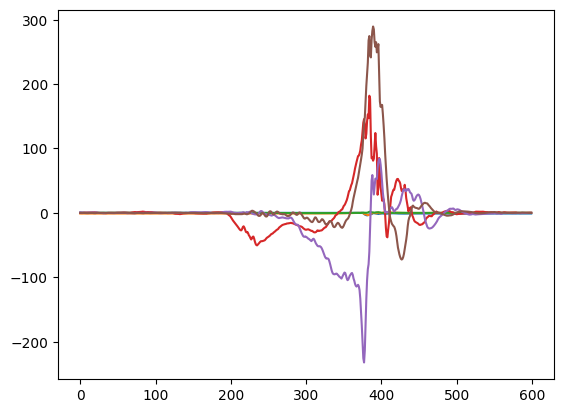

In [138]:
r = random.randint(0,100)
plt.plot(task_22_cut[r])

In [139]:
joblib.dump(np.array(task_01_cut), '../../assets/pkl/task_01_cut.pkl')
joblib.dump(np.array(task_06_cut), '../../assets/pkl/task_06_cut.pkl')
joblib.dump(np.array(task_20_cut), '../../assets/pkl/task_20_cut.pkl')
joblib.dump(np.array(task_21_cut), '../../assets/pkl/task_21_cut.pkl')
joblib.dump(np.array(task_22_cut), '../../assets/pkl/task_22_cut.pkl')

['../../assets/pkl/task_22_cut.pkl']

In [140]:
clean_t01 = joblib.load('../../assets/pkl/task_01_cut.pkl')
clean_t06 = joblib.load('../../assets/pkl/task_06_cut.pkl')
clean_t20 = joblib.load('../../assets/pkl/task_20_cut.pkl')
clean_t21 = joblib.load('../../assets/pkl/task_21_cut.pkl')
clean_t22 = joblib.load('../../assets/pkl/task_22_cut.pkl')

print(f'Jumlah Data Task 01: {clean_t01.shape}')
print(f'Jumlah Data Task 06: {clean_t06.shape}')
print(f'Jumlah Data Task 20: {clean_t20.shape}')
print(f'Jumlah Data Task 21: {clean_t21.shape}')
print(f'Jumlah Data Task 22: {clean_t22.shape}')

Jumlah Data Task 01: (32, 600, 6)
Jumlah Data Task 06: (151, 600, 6)
Jumlah Data Task 20: (128, 600, 6)
Jumlah Data Task 21: (136, 600, 6)
Jumlah Data Task 22: (137, 600, 6)


In [141]:
all_clean_data = np.vstack([clean_t01, clean_t06, clean_t20, clean_t21, clean_t22])
all_clean_data.shape

(584, 600, 6)

In [142]:
joblib.dump(all_clean_data, '../../assets/pkl/dataset_v01.pkl')

['../../assets/pkl/dataset_v01.pkl']

In [143]:
labels_t01 = [1 for i in range(32)]
labels_t06 = [6 for i in range(151)]
labels_t20 = [20 for i in range(128)]
labels_t21 = [21 for i in range(136)]
labels_t22 = [22 for i in range(137)]

labels = labels_t01 + labels_t06 + labels_t20 + labels_t21 + labels_t22
labels = np.array(labels)
labels.shape

(584,)

In [144]:
joblib.dump(labels, '../../assets/pkl/labels_v01.pkl')

['../../assets/pkl/labels_v01.pkl']

# Training Data

In [145]:
# Names of your bucket and files
bucket_name = "fall-detection-bucket"
dataset_filename = 'pkl/dataset_v01.pkl'
labels_filename = 'pkl/labels_v01.pkl'

In [146]:
# Function to read a file from GCS into memory
def read_blob_to_memory(bucket_name, source_blob_name):
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    data = blob.download_as_bytes()
    print(f"Read {len(data)} bytes from {source_blob_name}.")
    return data

# Load dataset from GCS
try:
    dataset_bytes = read_blob_to_memory(bucket_name, dataset_filename)
    with io.BytesIO(dataset_bytes) as f:
        X = pickle.load(f, fix_imports=True, encoding='bytes')
except (pickle.UnpicklingError, EOFError, FileNotFoundError) as e:
    print(f"Error loading dataset: {e}\n")
    X = np.random.rand(100, 64, 64, 3)  # Example dataset in case of error

# Load labels from GCS
try:
    labels_bytes = read_blob_to_memory(bucket_name, labels_filename)
    with io.BytesIO(labels_bytes) as f:
        y = pickle.load(f, fix_imports=True, encoding='bytes')
except (pickle.UnpicklingError, EOFError, FileNotFoundError) as e:
    print(f"Error loading labels: {e} \n")
    y = np.random.randint(0, 10, 100)  # Example labels in case of error

# Ensure they are numpy arrays
x = np.array(X)
y = np.array(y)

print("Data loaded successfully.")

Read 16819441 bytes from pkl/dataset_v01.pkl.
Error loading dataset: invalid load key, '\x0d'.

Read 2561 bytes from pkl/labels_v01.pkl.
Error loading labels: invalid load key, '\x02'. 

Data loaded successfully.


In [147]:
dataset = joblib.load('../../assets/pkl/dataset_v01.pkl')
labels = joblib.load('../../assets/pkl/labels_v01.pkl')

print(dataset.shape)
print(labels.shape)

(584, 600, 6)
(584,)


In [148]:
dataset = np.swapaxes(dataset, 1, 2)
dataset.shape

(584, 6, 600)

In [149]:
dataset[0]

array([[-5.3000000e-02, -5.4000000e-02, -5.6000000e-02, ...,
        -5.3000000e-02, -5.3000000e-02, -5.2000000e-02],
       [-1.0040000e+00, -1.0070000e+00, -1.0090000e+00, ...,
        -1.0080000e+00, -1.0090000e+00, -1.0100000e+00],
       [ 0.0000000e+00,  0.0000000e+00, -4.0000000e-03, ...,
        -2.0000000e-03, -2.0000000e-03, -7.0000000e-03],
       [-5.7295800e-02, -5.7295800e-02, -4.5836640e-01, ...,
        -1.4896908e+00, -1.5469866e+00, -1.7188740e+00],
       [ 4.0107060e-01,  2.2918320e-01,  2.8647900e-01, ...,
         2.2345362e+00,  1.9480572e+00,  1.7188740e+00],
       [ 3.4377480e-01,  2.2918320e-01,  1.7188740e-01, ...,
         1.1459160e-01,  5.7295800e-02,  0.0000000e+00]])

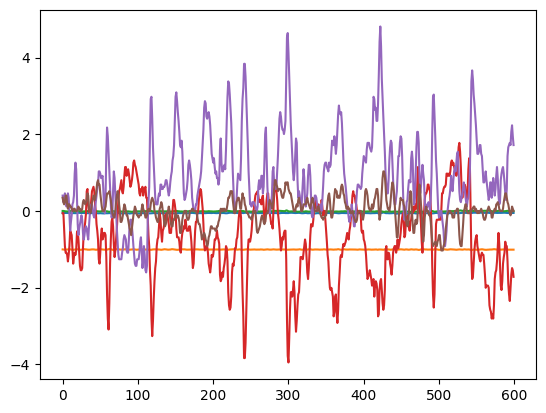

In [150]:
plt.plot(dataset[0].transpose())

In [163]:
X = X / 255.0

lb = LabelBinarizer()
y = lb.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [164]:
model = Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,490 (2.61 MB)

 Trainable params: 684,490 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [165]:
train_accs = []
test_accs = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

for train_index, test_index in kfold.split(dataset, labels):
    _, gyro_dim, data_len = dataset.shape

    X_train = dataset[train_index]
    X_test = dataset[test_index]

    X_train = X_train.reshape(X_train.shape[0], gyro_dim, data_len, 1)
    X_test = X_test.reshape(X_test.shape[0], gyro_dim, data_len, 1)

    y_train = labels[train_index].reshape(-1, 1)
    y_test = labels[test_index].reshape(-1, 1)

    ohe = OneHotEncoder(sparse_output=False)
    y_train = ohe.fit_transform(y_train)
    y_test = ohe.transform(y_test)

    cnn = Sequential()
    cnn.add(Input(shape=(gyro_dim, data_len, 1)))
    cnn.add(Conv2D(filters=32, kernel_size=(2,2), strides=2, padding='same', activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    cnn.add(Conv2D(filters=16, kernel_size=(2,2), strides=2, padding='same', activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    cnn.add(Flatten())
    cnn.add(Dense(units=64, activation='relu'))
    cnn.add(Dense(units=32, activation='relu'))
    cnn.add(Dense(units=16, activation='relu'))
    cnn.add(Dense(units=5, activation='softmax'))

    cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = cnn.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), verbose=0)

    _, train_acc = cnn.evaluate(X_train, y_train, verbose=0)
    _, test_acc = cnn.evaluate(X_test, y_test, verbose=0)

    print('---------------------')
    print(f'Fold no: {fold}')
    print(f'Train Accuracy: {train_acc * 100:.2f}% || Test Accuracy: {test_acc * 100:.2f}%')

    train_accs.append(train_acc)
    test_accs.append(test_acc)

    fold += 1

train_avg = np.mean(train_accs)
test_avg = np.mean(test_accs)

print()
print(f'Train Avg Acc: {train_avg:.5f}')
print(f'Test Avg Acc: {test_avg:.5f}')

---------------------
Fold no: 1
Train Accuracy: 100.00% || Test Accuracy: 97.44%
---------------------
Fold no: 2
Train Accuracy: 100.00% || Test Accuracy: 96.58%
---------------------
Fold no: 3
Train Accuracy: 100.00% || Test Accuracy: 94.87%
---------------------
Fold no: 4
Train Accuracy: 100.00% || Test Accuracy: 99.15%
---------------------
Fold no: 5
Train Accuracy: 100.00% || Test Accuracy: 95.69%

Train Avg Acc: 1.00000
Test Avg Acc: 0.96745


In [169]:
X_train_final = dataset.reshape(dataset.shape[0], dataset.shape[1], dataset.shape[2], 1)
y_train_final = ohe.fit_transform(labels.reshape(-1, 1))

model = Sequential([
    Input(shape=(dataset.shape[1], dataset.shape[2], 1)),
    Conv2D(32, (2, 2), strides=2, padding='same', activation='relu'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(16, (2, 2), strides=2, padding='same', activation='relu'),
    MaxPooling2D((2, 2), padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_final, y_train_final, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.6295 - loss: 1.0489 - val_accuracy: 0.0171 - val_loss: 3.4884
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8952 - loss: 0.2247 - val_accuracy: 0.1538 - val_loss: 3.0927
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9225 - loss: 0.1462 - val_accuracy: 0.2137 - val_loss: 3.2436
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9347 - loss: 0.1143 - val_accuracy: 0.2564 - val_loss: 2.9309
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9861 - loss: 0.1099 - val_accuracy: 0.2735 - val_loss: 2.8824
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9994 - loss: 0.0983 - val_accuracy: 0.2821 - val_loss: 3.0098
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9934 - loss: 0.1010 - val_accuracy: 0.2906 - val_loss: 3.1325
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0684 - val_accuracy: 0.2991 - 

In [170]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9407 - loss: 0.3645 
Test accuracy: 0.8620689511299133


In [177]:
model.save("../../assets/model/model.h5")
keras.saving.save_model(model, "../../assets/model/model.keras")
model.save_weights("../../assets/model/model_weight.weights.h5")